In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
from scipy.optimize import least_squares

# V52 lidar study

In [2]:
tstart,tend = 40, 50
xstart,xend = 22.63, 23.98

In [3]:
vlos_data = '/Users/equon/WakeDynamics/V52_lidar_wake/vlos_digitized.csv'

## read digitized data 
- image from https://www.vindenergi.dtu.dk/english/news/2018/12/new-generation-of-wind-scanners-developed-by-dtu?id=21486c47-1a16-45da-b7f2-afad61e867e7
- digitized using https://apps.automeris.io/wpd/

In [4]:
df = pd.read_csv(vlos_data,header=None,names=['t','vlos'])

In [5]:
# distance from lidar [m]
df['x'] = (df['t']-tstart)/(tend-tstart) * (xend-xstart) + xstart

(-8, 8)

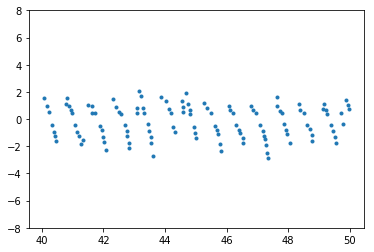

In [6]:
plt.plot(df['t'],df['vlos'],'.')
plt.ylim((-8,8))

## estimate passage frequency

In [7]:
dt = 0.1
t = np.arange(40+dt,50,dt)
Nt = len(t)

In [8]:
vlos = np.interp(t, df['t'], df['vlos'])

In [9]:
f = np.fft.fftfreq(Nt,d=dt)
S = np.fft.fft(vlos)

In [10]:
PSD = np.abs(S[:Nt//2])**2
imax = np.argmax(PSD)
fmax = f[imax]
print(fmax)

1.3131313131313131


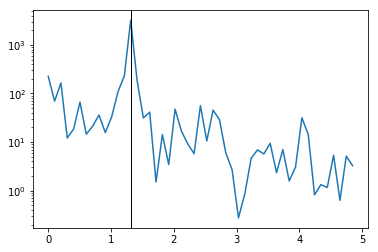

In [11]:
fig,ax = plt.subplots()
ax.semilogy(f[:Nt//2], PSD)
ax.axvline(fmax, color='k', lw=1)

In [12]:
T = 1/fmax
rotor_period = 3*T # 3 blades
rotor_rpm = 1/rotor_period * 60 # should be between 14 - 31.4 rpm
print('time between vortex passage:',T)
print(rotor_rpm,'rpm')

time between vortex passage: 0.7615384615384615
26.262626262626263 rpm


## split up periods

In [13]:
tlimits = np.arange(tstart,tend+T,T)

In [14]:
tlimits

array([40.        , 40.76153846, 41.52307692, 42.28461538, 43.04615385,
       43.80769231, 44.56923077, 45.33076923, 46.09230769, 46.85384615,
       47.61538462, 48.37692308, 49.13846154, 49.9       , 50.66153846])

In [15]:
df['period'] = pd.cut(df['t'], tlimits, labels=range(len(tlimits)-1))

(40, 50)

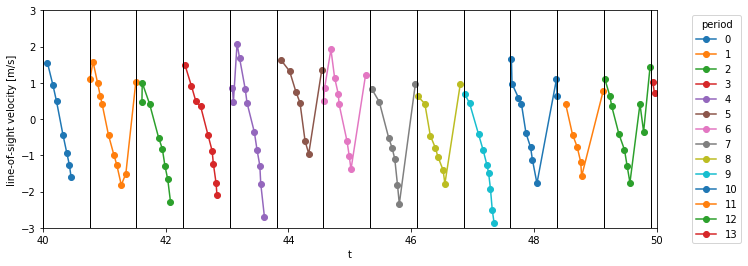

In [16]:
fig,ax = plt.subplots(figsize=(11,4))
df.set_index('t').pivot(columns='period')['vlos'].plot(ax=ax,marker='o')
for ti in tlimits:
    ax.axvline(ti,color='k',lw=1)
ax.legend(loc='upper left',bbox_to_anchor=(1.05,1),title='period')
ax.set_ylabel('line-of-sight velocity [m/s]')
ax.set_ylim((-3,3))
ax.set_xlim((tstart,tend))

## fit line of vortices to data

### vortex models

In [17]:
def rankine(r,**params):
    """Rankine vortex model
    
    For the core radius, there is an implicit conversion from time to length.
    """
    utheta = params['strength'] / (2*np.pi*r)
    in_core = np.where(np.abs(r) < params['rc'])
    utheta[in_core] = params['strength'] * r[in_core] / (2*np.pi*params['rc']**2)
    return utheta

In [18]:
def lamb_oseen(r,**params):
    """Lamb-Oseen vortex model
    
    A generalized Gaussian width is used for the denominator of the exponent of
    the auxiliary scaling function
    """
    g = 1 - np.exp(-r**2 / params['epsilon'])
    utheta = params['strength'] / (2*np.pi*r) * g
    utheta[r==0] = 0
    return utheta

### vortex line solution

In [19]:
def vort_line_soln(r,model=rankine,tol=0.003,Nvort=None,**params):
    """Calculate solution for a line of vortices with the same orientation, neglecting
    mutual inductance. The tolerance determines the number of additional vortices to
    account for so that the induced velocity from the farthest vortex is `tol` m/s.
    
    Vortex model params:
    - separation: time between passage of subsequent vortices [s]
    - strength: vortex strength [m^2/s]
    - tref: time at which first vortex appears [s]
    - vbias: bias in vertical velocity, to account for wake expansion [m/s]
    - rcfrac: core radius, as a fraction of the separation distance [-]
    """
    T = params['separation']
    if 'rcfrac' in params.keys():
        rcfrac = params.get('rcfrac')
        params['rc'] = rcfrac * T
    r0 = np.mod(r-params['tref']+T/2, T) - T/2
    u = model(r0, **params)
    if Nvort is None:
        Nvort = params['strength'] / (2*np.pi*T) / tol
        Nvort = int(np.ceil(Nvort))
        #print('Accounting for',Nvort,'other vortices')
    for i in range(1,Nvort+1):
        u += model(r0-i*T, **params)
        u += model(r0+i*T, **params)
    return u + params['vbias']

/Users/equon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


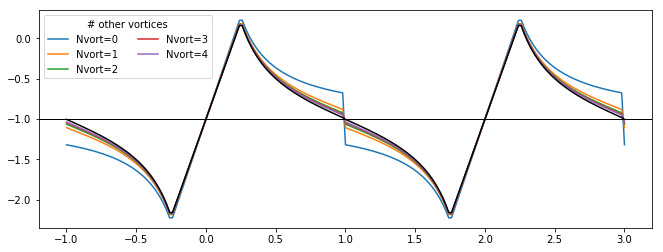

In [20]:
# test convergence for increasing number of vortices included
testparams = dict(separation=2,strength=2,tref=0,vbias=-1,rc=0.25)

r0 = np.linspace(-1,3,201)
fig,ax = plt.subplots(figsize=(11,4))
for n in range(5):
    ax.plot(r0, vort_line_soln(r0,Nvort=n,**testparams), label='Nvort={:d}'.format(n))
ax.plot(r0, vort_line_soln(r0,**testparams), 'k')
ax.axhline(-1,color='k',lw=1)
ax.legend(ncol=2,title='# other vortices')

/Users/equon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/equon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


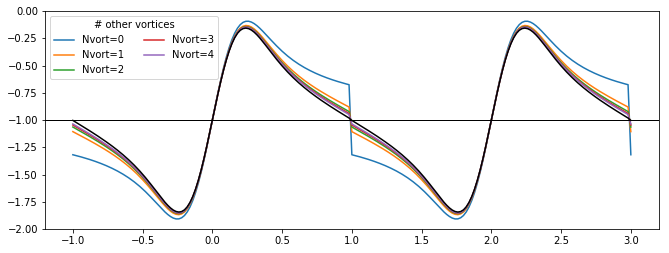

In [21]:
# test convergence for increasing number of vortices included
testmodel = lamb_oseen
testparams = dict(separation=2,strength=2,tref=0,vbias=-1,epsilon=0.05)

r0 = np.linspace(-1,3,201)
fig,ax = plt.subplots(figsize=(11,4))
for n in range(5):
    ax.plot(r0, vort_line_soln(r0,model=testmodel,Nvort=n,**testparams), label='Nvort={:d}'.format(n))
ax.plot(r0, vort_line_soln(r0,model=testmodel,**testparams), 'k')
ax.axhline(-1,color='k',lw=1)
ax.legend(ncol=2,title='# other vortices')

### do the optimization

In [22]:
def optimize_vort_soln(model,params_guess_bounds):
    """Perform least-squares optimization for the solution from a line of vortices,
    given a vortex model and a set of parameters to be optimized.
    """
    guess = []
    bounds = [[],[]]
    for param, guess_bounds in params_guess_bounds.items():
        guess.append(guess_bounds[0])
        bnds = guess_bounds[1]
        bounds[0].append(bnds[0])
        bounds[1].append(bnds[1])
        print(param,'guess/bounds:',guess[-1],(bounds[0][-1],bounds[1][-1]))
    def optfun(x):
        vortparams = {key: val for key,val in zip(params_guess_bounds.keys(), x)}
        uthe = vort_line_soln(df['t'].values, model=model, **vortparams)
        return uthe - df['vlos']
    return least_squares(optfun, guess, bounds=bounds, verbose=2)

In [23]:
def plot_vort_soln(model,soln,params):
    fig,ax = plt.subplots(figsize=(11,4))

    # lidar data
    df.set_index('t').pivot(columns='period')['vlos'].plot(ax=ax,marker='o',markersize=4)

    # optimized vortex solution, at same times as lidar data
    vortparams = {key: val for key,val in zip(params.keys(), soln)}
    vlos = vort_line_soln(df['t'].values, model=model, **vortparams)
    ax.plot(df['t'], vlos, 'ko', markerfacecolor='none', label='optimized\nmodel')

    # show vortex solution at higher resolution
    tt = np.linspace(40,50,1001)
    vlos_hi = vort_line_soln(tt, model=model, **vortparams)
    ax.plot(tt, vlos_hi, 'k-', lw=1)

    # formatting
    ax.legend(loc='upper left',bbox_to_anchor=(1.05,1),
              title='period',ncol=2)
    ax.set_ylabel('line-of-sight velocity [m/s]')
    ax.set_ylim((-3,3))
    ax.set_title(r'{:s} vortex : $\Gamma$={:g} m$^2$/s, est. RPM={:g}, $V_{{los}}$ bias={:g} m/s'.format(
        model.__name__, vortparams['strength'], 60./(3*vortparams['separation']), vortparams['vbias']
    ))

    for key,val in vortparams.items():
        print(key,val)
        
    return fig,ax

strength guess/bounds: 1.0 (0.5, 5.0)
separation guess/bounds: 0.7615384615384615 (0.5, 1.0)
tref guess/bounds: 40 (39.0, 41.0)
vbias guess/bounds: -0.5 (-1, 0)
rcfrac guess/bounds: 0.2 (0.01, 0.5)
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.8610e+01                                    6.39e+02    
       1              2         2.9791e+01      2.88e+01       6.95e-01       1.80e+02    
       2              3         1.4619e+01      1.52e+01       5.28e-01       7.77e+01    
       3              4         1.3408e+01      1.21e+00       9.84e-02       8.15e+00    
       4              5         1.3398e+01      1.03e-02       1.86e-02       1.15e+00    
       5              6         1.3398e+01      5.77e-05       3.12e-04       3.64e-02    
       6              7         1.3398e+01      3.59e-07       1.21e-04       8.00e-03    
       7              8         1.3398e+01      2.27e-09       1.79e-06   

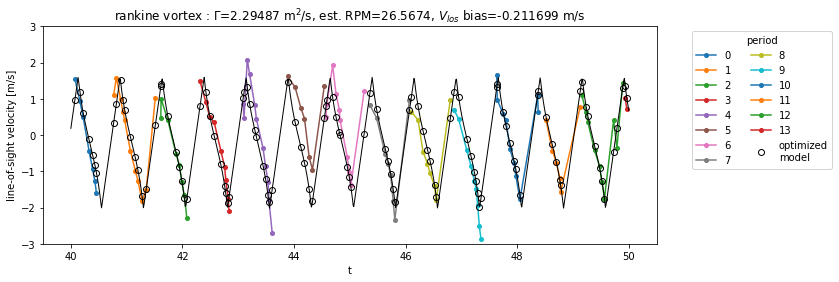

In [24]:
model = rankine
params = OrderedDict(
    strength=[1.0, (0.5, 5.0)],
    separation=[T, (0.5, 1.0)],
    tref=[tstart, (tstart-1.0, tstart+1.0)],
    vbias=[-0.5, (-1, 0)],
    rcfrac=[0.2, (0.01, 0.5)],
)

soln = optimize_vort_soln(model, params)

errors = soln['fun']
print('L2 error =',np.sqrt(errors.dot(errors)))

fig,ax = plot_vort_soln(model, soln['x'], params)
fig.savefig('figures/{:s}_soln.png'.format(model.__name__), bbox_inches='tight')

strength guess/bounds: 1.0 (0.5, 5.0)
separation guess/bounds: 0.7615384615384615 (0.5, 1.0)
tref guess/bounds: 40 (39.0, 41.0)
vbias guess/bounds: -0.5 (-1, 0)
epsilon guess/bounds: 0.1 (0.01, 0.5)
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.0858e+01                                    9.07e+01    
       1              5         7.8092e+01      2.77e+00       1.18e-02       2.96e+01    
       2              6         7.7275e+01      8.17e-01       1.36e-02       3.37e+01    
       3              7         7.6471e+01      8.04e-01       1.23e-02       3.75e+01    
       4              8         7.5638e+01      8.32e-01       1.30e-02       4.19e+01    
       5              9         7.4802e+01      8.36e-01       1.21e-02       4.52e+01    
       6             10         7.3922e+01      8.80e-01       1.29e-02       4.94e+01    
       7             11         7.3051e+01      8.72e-01       1.21e-02  

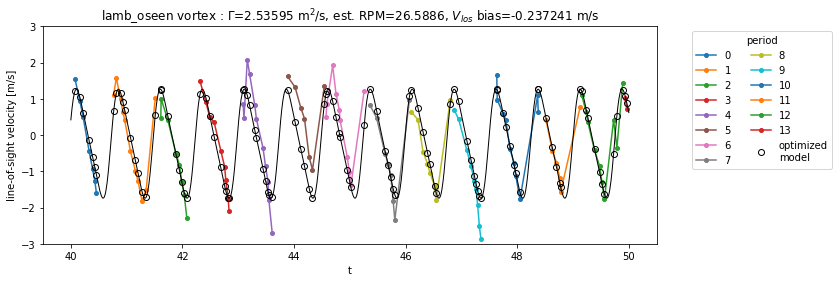

In [25]:
model = lamb_oseen
params = OrderedDict(
    strength=[1.0, (0.5, 5.0)],
    separation=[T, (0.5, 1.0)],
    tref=[tstart, (tstart-1.0, tstart+1.0)],
    vbias=[-0.5, (-1, 0)],
    epsilon=[0.1, (0.01, 0.5)],
)

soln = optimize_vort_soln(model, params)

errors = soln['fun']
print('L2 error =',np.sqrt(errors.dot(errors)))

fig,ax = plot_vort_soln(model, soln['x'], params)
fig.savefig('figures/{:s}_soln.png'.format(model.__name__), bbox_inches='tight')